# 0. Imports

In [ ]:
# # ideias adicionais:
#     - criar coluna gênero de quem anunciou
#     - criar coluna CEP
#     -

In [241]:
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 1000)

from sklearn.covariance import EllipticEnvelope

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.6 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29881 sha256=98966dd2b41255a402a88d8b5d58c63b1f1f44847f900f3aa5333ae0f421a842
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=3533c19e9c40ab48d957073ea64943b76a80b00b53da1e8e35766e73208bb2ec
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


# 1. Coletar dados

In [4]:
# <explicar como foi feita a coleta de dados e onde localizar .py>

| Campop               | Descrição                                      |
|----------------------|--------------------------------------------------|
| find_anuncio         | o titulo do anuncio                              |
| find_condominio      | o preço do condominio                            |
| find_descri          | a descrição feita do imovel                      |
| find_endereco        | Endereço = bairro, Cidade, estado, cep           |
| find_iptu            | IPTU                                             |
| find_loc             | geralmente a rua                                 |
| find_m_quadrado      | Tamanho do imóvel em metros quadrados            |
| find_price           | Preço do imóvel                                  |
| find_vendedor        | Informações sobre o vendedor                     |
| is_academia          | Indica se há academia/centro de fitness          |
| is_apartamento       | Indica se é um apartamento                       |
| is_ar_condicionado   | Indica se tem ar condicionado                     |
| is_churrasqueira     | Indica se há churrasqueira                       |
| is_elevador          | Indica se há elevador                            |
| is_mobiliado         | Indica se o imóvel está mobiliado                |
| is_piscina           | Indica se há piscina                             |
| is_portaria          | Indica se há portaria/serviço de portaria        |
| is_profissional      | Indica se o vendedor é um profissional           |
| is_salao_festa       | Indica se há salão de festas/área de eventos     |
| is_varanda           | Indica se há varanda                             |
| n_banheiros          | Número de banheiros                              |
| n_fotos              | Número de fotos no anúncio                       |
| n_garagens           | Número de vagas/garagens                         |
| n_quartos            | Número de quartos                                |

In [12]:
path_raw = '/content/scraped_data.csv'
df_raw = pd.read_csv(path_raw, sep=',', nrows=5000)

In [13]:
df_raw.head(3)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,True,False,False,False,False,False,False,True,False,False,3,20,0,3
1,Apartamento para venda possui 51 metros quadra...,R$ 0 / mês,Código do anúncio: S623-1\n\nO apartamento no ...,"Boa Viagem, Recife, PE, 51021130",R$ 0,Rua Coronel Anízio Rodrigues Coelho,51m²,525000,Dream Residence Imóveis Recife,False,True,False,False,False,False,True,False,True,True,False,2,15,1,3
2,Apartamento para venda possui 124 metros quadr...,R$ 822 / mês,Código do anúncio: V2009TS-2225\n\nApartamento...,"Boa Viagem, Recife, PE, 51130000",R$ 291,Avenida Boa Viagem - de 6200/6201 ao fim,124m²,620000,Roberta Gadelha Batista,False,True,False,False,False,False,False,False,True,False,False,2,14,1,3


# 2. Realizar pré-processamento dos dados

In [176]:
df_raw.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5000, 24)

In [177]:
df_0 = df_raw.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [178]:
# vamos considerar como chave todas as colunas menos
df_0 = df_0.drop_duplicates(subset=['find_condominio','find_endereco','find_iptu','find_loc', 'find_m_quadrado', 'find_price', 'find_vendedor', 'is_academia', 'is_apertamento', 'is_ar_condicionado', 'is_churrasqueira', 'is_elevador', 'is_mobiliado', 'is_piscina', 'is_portaria', 'is_profissional', 'is_salao_festa', 'is_varanda', 'n_banheiros', 'n_fotos', 'n_garagens', 'n_quartos'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [179]:
set(df_0.columns) - set(['find_condominio','find_endereco','find_iptu','find_loc', 'find_m_quadrado', 'find_price', 'find_vendedor', 'is_academia', 'is_apertamento', 'is_ar_condicionado', 'is_churrasqueira', 'is_elevador', 'is_mobiliado', 'is_piscina', 'is_portaria', 'is_profissional', 'is_salao_festa', 'is_varanda', 'n_banheiros', 'n_fotos', 'n_garagens', 'n_quartos'])

# chave primária vai ser todas as colunas menos o que texto que tem no anuncio e na descrição dele

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'find_anuncio', 'find_descri'}

In [180]:
df_0.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4890, 24)

## 2.0 <dar nome melhor para descrever essas alterações iniciais>

### 2.0.1 Algumas classes são muito uteis como valor numerico, mas não podem ser totalmente convertidas. exemplo: o numero de quartos tem o campo '5 ou mais' vamos fazer o drop desses valores

In [181]:
df_0 = df_0[df_0['n_quartos'] != '5 ou mais']
df_0 = df_0[df_0['n_banheiros'] != '5 ou mais']
df_0 = df_0[df_0['n_garagens'] != '5 ou mais']

df_0 = df_0[df_0['find_price'] > 0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.1 definição de tipos e criação de novas colunas derivadas

In [182]:
df_0.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


find_anuncio          object
find_condominio       object
find_descri           object
find_endereco         object
find_iptu             object
find_loc              object
find_m_quadrado       object
find_price             int64
find_vendedor         object
is_academia             bool
is_apertamento          bool
is_ar_condicionado      bool
is_churrasqueira        bool
is_elevador             bool
is_mobiliado            bool
is_piscina              bool
is_portaria             bool
is_profissional         bool
is_salao_festa          bool
is_varanda              bool
n_banheiros           object
n_fotos                int64
n_garagens            object
n_quartos             object
dtype: object

In [183]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_anuncio'] = df_0['find_anuncio'].astype('category')
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['find_descri'] = df_0['find_descri'].astype('category')
df_0['find_endereco'] = df_0['find_endereco'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('float')
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('float')
df_0['n_quartos'] = df_0['n_quartos'].astype('float')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
df_0.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


find_anuncio          category
find_condominio        float64
find_descri           category
find_endereco         category
find_iptu              float64
find_loc              category
find_m_quadrado        float64
find_price             float64
find_vendedor         category
is_academia           category
is_apertamento        category
is_ar_condicionado    category
is_churrasqueira      category
is_elevador           category
is_mobiliado          category
is_piscina            category
is_portaria           category
is_profissional       category
is_salao_festa        category
is_varanda            category
n_banheiros            float64
n_fotos                float64
n_garagens             float64
n_quartos              float64
dtype: object

In [185]:
df_0[df_0.select_dtypes(['category']).columns] = df_0.select_dtypes(['category']).apply(lambda x: x.cat.codes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [186]:
df_0.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


find_anuncio            int16
find_condominio       float64
find_descri             int16
find_endereco           int16
find_iptu             float64
find_loc                int16
find_m_quadrado       float64
find_price            float64
find_vendedor           int16
is_academia              int8
is_apertamento           int8
is_ar_condicionado       int8
is_churrasqueira         int8
is_elevador              int8
is_mobiliado             int8
is_piscina               int8
is_portaria              int8
is_profissional          int8
is_salao_festa           int8
is_varanda               int8
n_banheiros           float64
n_fotos               float64
n_garagens            float64
n_quartos             float64
dtype: object

## 2.2 Tratamento de dados ausentes
  - vamos fazer a imputação das únicas 3 colunas que apresentam preenchimento vazio
    - find_m_quadrado
    - n_banheiros
    - n_garagens

In [187]:
df_0.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


find_anuncio            0
find_condominio         0
find_descri             0
find_endereco           0
find_iptu               0
find_loc                0
find_m_quadrado        32
find_price              0
find_vendedor           0
is_academia             0
is_apertamento          0
is_ar_condicionado      0
is_churrasqueira        0
is_elevador             0
is_mobiliado            0
is_piscina              0
is_portaria             0
is_profissional         0
is_salao_festa          0
is_varanda              0
n_banheiros             7
n_fotos                 0
n_garagens            116
n_quartos               0
dtype: int64

### 2.2.1 Removendo colunas pelo knnimputer

In [188]:
from fancyimpute import KNN

df_0_knn = KNN(k=2).fit_transform(df_0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Imputing row 1/4557 with 0 missing, elapsed time: 4.561
Imputing row 101/4557 with 0 missing, elapsed time: 4.563
Imputing row 201/4557 with 0 missing, elapsed time: 4.565
Imputing row 301/4557 with 0 missing, elapsed time: 4.566
Imputing row 401/4557 with 0 missing, elapsed time: 4.567
Imputing row 501/4557 with 0 missing, elapsed time: 4.570
Imputing row 601/4557 with 0 missing, elapsed time: 4.571
Imputing row 701/4557 with 0 missing, elapsed time: 4.572
Imputing row 801/4557 with 0 missing, elapsed time: 4.572
Imputing row 901/4557 with 0 missing, elapsed time: 4.573
Imputing row 1001/4557 with 0 missing, elapsed time: 4.573
Imputing row 1101/4557 with 0 missing, elapsed time: 4.574
Imputing row 1201/4557 with 0 missing, elapsed time: 4.578
Imputing row 1301/4557 with 0 missing, elapsed time: 4.579
Imputing row 1401/4557 with 0 missing, elapsed time: 4.580
Imputing row 1501/4557 with 0 missing, elapsed time: 4.581
Imputing row 1601/4557 with 0 missing, elapsed time: 4.582
Imputing 

In [189]:
df_0 = pd.DataFrame(data=df_0_knn[0:,0:],columns=df_0.columns)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [190]:
df_0.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


find_anuncio          0
find_condominio       0
find_descri           0
find_endereco         0
find_iptu             0
find_loc              0
find_m_quadrado       0
find_price            0
find_vendedor         0
is_academia           0
is_apertamento        0
is_ar_condicionado    0
is_churrasqueira      0
is_elevador           0
is_mobiliado          0
is_piscina            0
is_portaria           0
is_profissional       0
is_salao_festa        0
is_varanda            0
n_banheiros           0
n_fotos               0
n_garagens            0
n_quartos             0
dtype: int64

## 2.3 Normalização e discretização dos dados

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='dist_find_m_quadrado'>

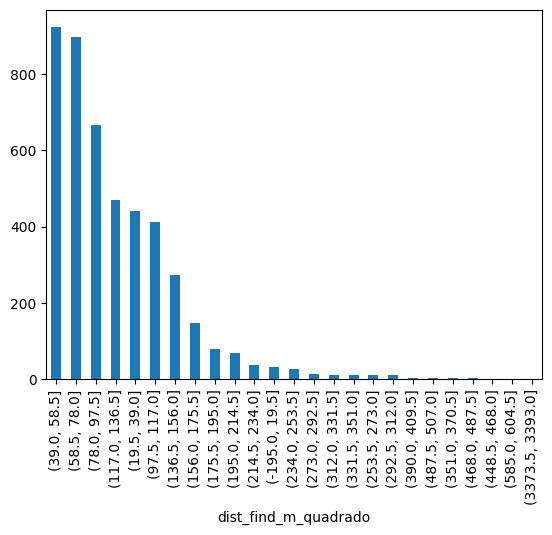

In [193]:
# fazendo a discretização do find_m_quadrado para entender melhor distribuição pelos segmentos
df_disc = df_0.copy()
df_disc['dist_find_m_quadrado'] = pd.cut(df_disc['find_m_quadrado'], bins=10000)

df_disc['dist_find_m_quadrado'].value_counts()[:25].plot(kind='bar')

In [194]:
# minmax em todo o dataframe
df_0_norm = (df_0 - df_0.min()) / (df_0.max() - df_0.min()).copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [195]:
df_0_norm.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
count,4557.000000,4557.000000,4557.000000,4557.000000,4.557000e+03,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000
mean,0.482763,0.001111,0.501437,0.406135,6.985622e-04,0.501175,0.000691,0.261314,0.490102,0.468071,0.964670,0.215054,0.436910,0.677200,0.062761,0.633092,0.614000,0.979372,0.639456,0.346939,0.456463,0.781249,0.364573,0.667654
std,0.281275,0.024979,0.289263,0.308122,1.536719e-02,0.282680,0.014812,0.175458,0.276655,0.499034,0.184633,0.410905,0.496058,0.467598,0.242558,0.482014,0.486884,0.142150,0.480211,0.476048,0.236903,0.251340,0.165810,0.219514
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.255073,0.000001,0.250938,0.111872,9.259251e-07,0.266588,0.000277,0.143434,0.245409,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.650000,0.250000,0.500000
50%,0.467506,0.000114,0.502317,0.335616,1.851850e-06,0.502370,0.000395,0.195972,0.497496,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.500000,0.900000,0.250000,0.750000
75%,0.720267,0.000504,0.751931,0.673516,2.787034e-04,0.744076,0.000615,0.333333,0.714524,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.950000,0.500000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.4 Limpeza dos dados

In [218]:
df_1 = df_0.copy()
df_1_norm = df_0_norm.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.4.1 univariado

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

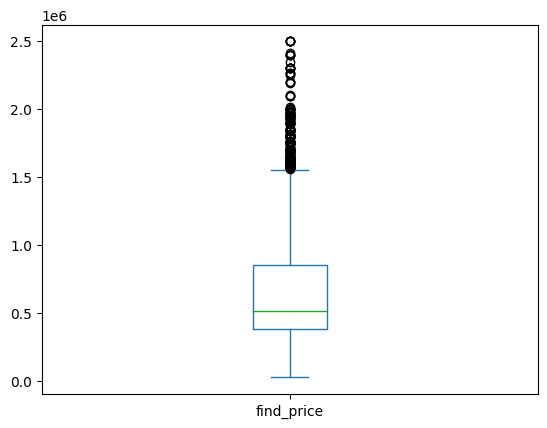

In [219]:
df_1['find_price'].plot.box()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

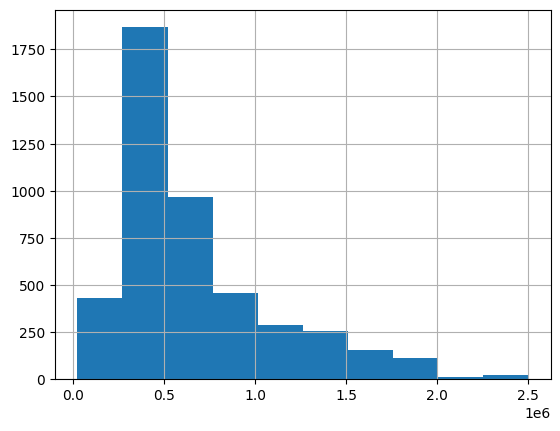

In [220]:
df_1['find_price'].hist()

In [221]:
from numpy import log10

df_1['log_find_price'] = log10(df_1['find_price'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

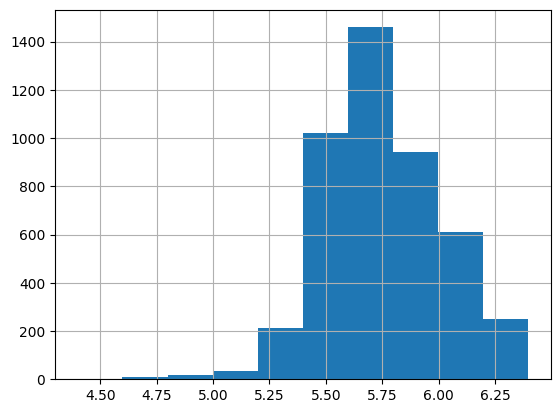

In [222]:
# sem melhoras significativas no shape da distribuição, vamos usar o find_price
df_1['log_find_price'].hist()

In [223]:
q1 = df_1['find_price'].quantile(q=0.25)
q3 = df_1['find_price'].quantile(q=0.75)
iqr = q3 - q1
print(iqr)


470000.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [224]:
# aplicando metodo tukey
print(len(df_1))
df_1 = df_1[(df_1['find_price'] > (q1-1.5*iqr)) & (df_1['find_price'] < (q3+1.5*iqr))]
print(len(df_1))

4557
4294


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [225]:
# sd

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [226]:
df_1.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,log_find_price
0,971.0,1100.0,1032.0,6.0,180.0,797.0,105.0,380000.0,59.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,5.579784
1,1499.0,0.0,2352.0,96.0,0.0,317.0,51.0,525000.0,147.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,15.0,1.0,3.0,5.720159
2,1381.0,822.0,2738.0,180.0,291.0,25.0,124.0,620000.0,489.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,14.0,1.0,3.0,5.792392


In [227]:
# ed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.4.2 bivariado

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='find_price', ylabel='n_banheiros'>

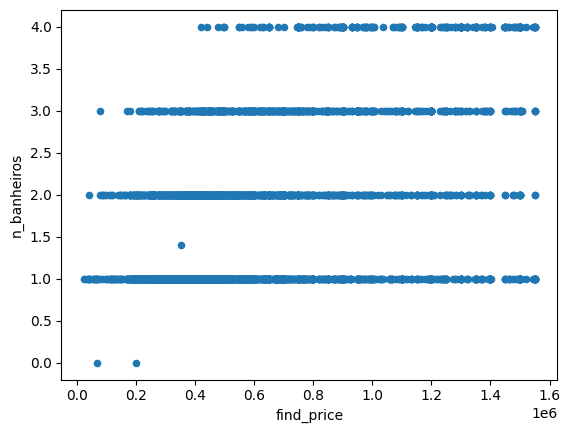

In [228]:
df_1.plot.scatter(x='find_price', y='n_banheiros')

In [229]:
df_1['price_qtdbanheiros'] = df_1['find_price'] / df_1['n_banheiros']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

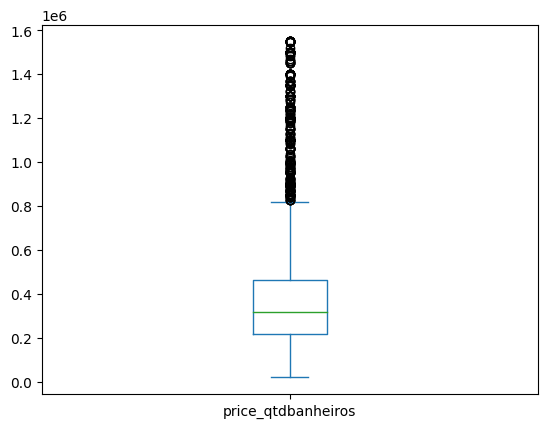

In [230]:
df_1['price_qtdbanheiros'].plot.box()

In [231]:
mad = abs(df_1['price_qtdbanheiros'] - df_1['price_qtdbanheiros'].median()).median()*(1/0.6745)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [232]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[abs(df_1['price_qtdbanheiros']-df_1['price_qtdbanheiros'].median())/mad < 3.5]
print(f'volumetria depois: {len(df_1)}')

volumetria antes: 4294
volumetria depois: 4047


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.4.3 multivariado

In [233]:
detector = EllipticEnvelope(contamination=0.01)
detector.fit(df_1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EllipticEnvelope(contamination=0.01)

In [234]:
df_1['outlier'] = detector.predict(df_1)
df_1.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-234-77740d809e07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['outlier'] = detector.predict(df_1)


,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,log_find_price,price_qtdbanheiros,outlier
0,971.0,1100.0,1032.0,6.0,180.0,797.0,105.0,380000.0,59.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,5.579784,126666.666667,1
1,1499.0,0.0,2352.0,96.0,0.0,317.0,51.0,525000.0,147.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.0,15.0,1.0,3.0,5.720159,262500.000000,1
2,1381.0,822.0,2738.0,180.0,291.0,25.0,124.0,620000.0,489.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,14.0,1.0,3.0,5.792392,310000.000000,1


In [235]:
print(f'volumetria antes: {len(df_1)}')
df_1 = df_1[df_1['outlier'] != -1]
print(f'volumetria depois: {len(df_1)}')

volumetria antes: 4047
volumetria depois: 4006


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 3. Apresentar estatísticas descritivas dos dados com visualizações

In [236]:
df_2 = df_1.copy()
df_2_norm = df_1_norm.copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


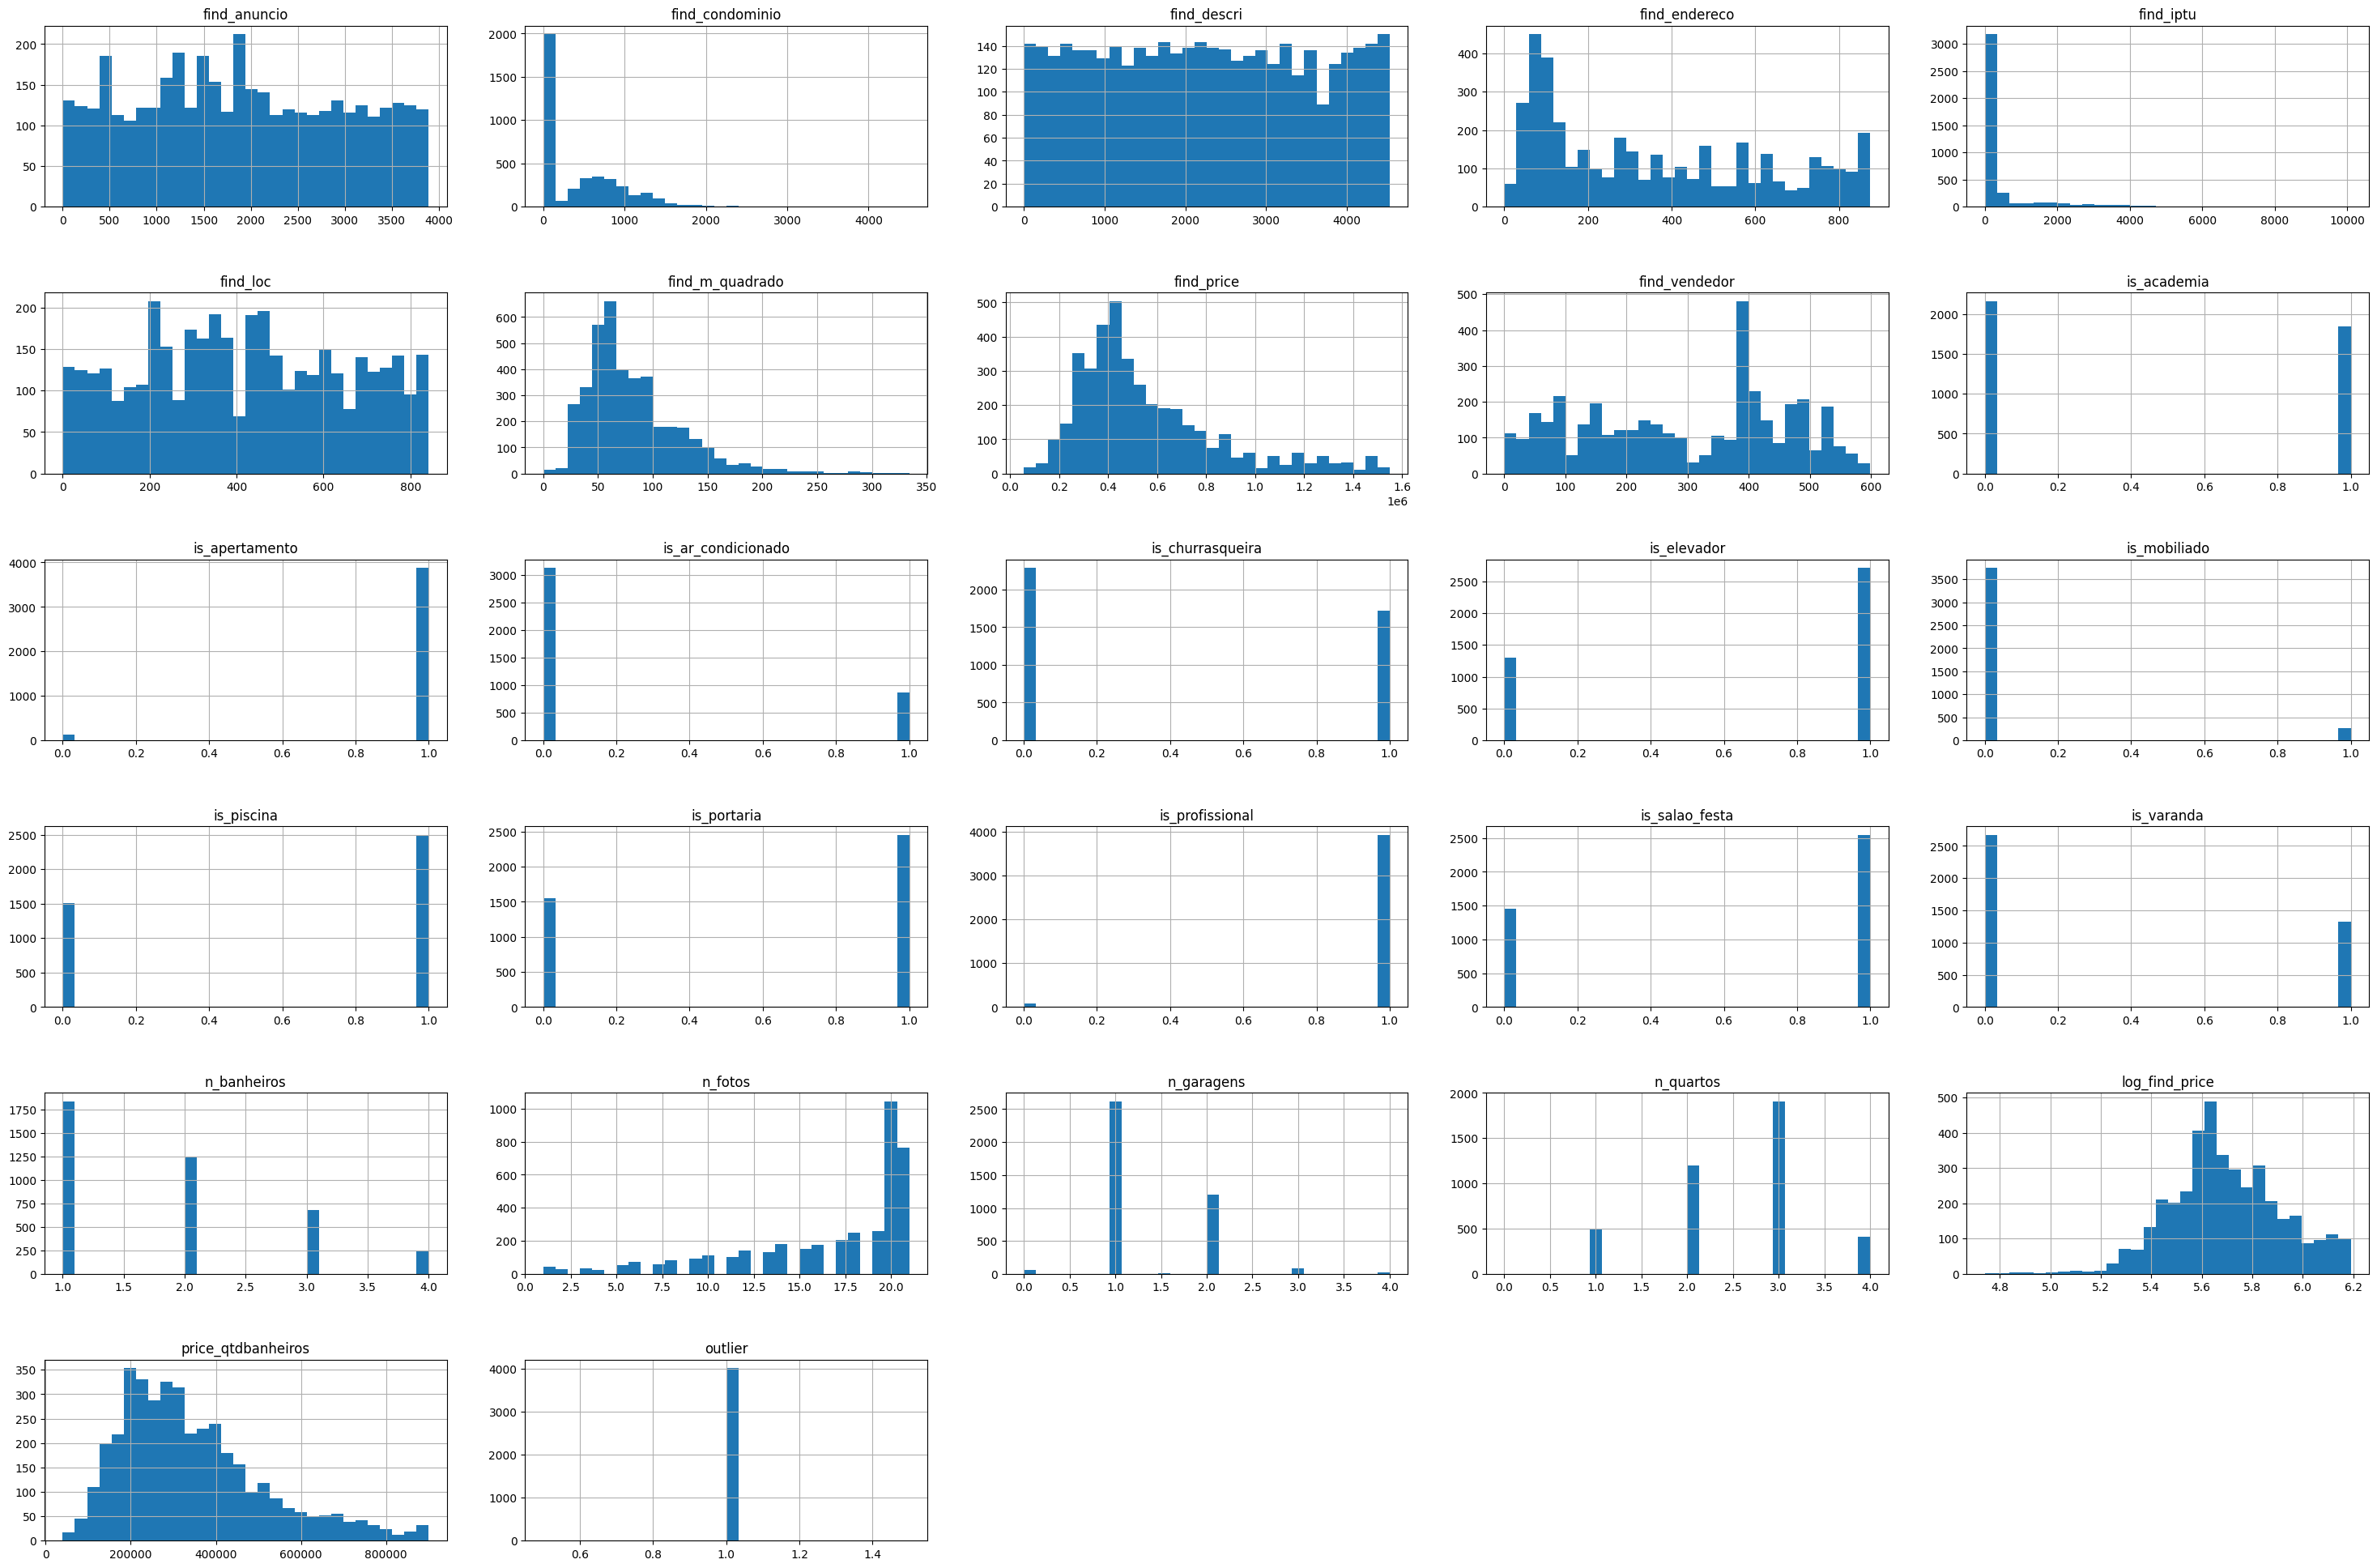

In [250]:
# TODO: escrever possíveis insights

df_2.hist(figsize=(30, 20), bins=30)

plt.tight_layout(pad=3.0)

In [249]:
df_2.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,log_find_price,price_qtdbanheiros,outlier
count,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4.006000e+03,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.000000,4006.0
mean,1893.428607,419.098352,2243.457064,356.529206,419.536945,418.413380,81.800544,5.643406e+05,296.541438,0.460310,0.968048,0.217424,0.429106,0.676985,0.064154,0.624314,0.612831,0.980030,0.636296,0.332252,1.832103,16.455816,1.344955,2.556915,5.695659,344676.919353,1.0
std,1096.521668,506.614437,1315.735126,268.612589,987.863427,234.922016,44.506743,3.003275e+05,165.510527,0.498484,0.175894,0.412545,0.495010,0.467687,0.245057,0.484360,0.487164,0.139915,0.481125,0.471079,0.916683,5.066590,0.573577,0.835320,0.221111,170727.851401,0.0
min,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,5.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.740363,40000.000000,1.0
25%,1009.250000,1.000000,1103.250000,108.000000,0.000000,223.000000,51.870911,3.648220e+05,147.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,14.000000,1.000000,2.000000,5.562081,216675.000000,1.0
50%,1845.500000,170.000000,2219.500000,294.000000,1.000000,416.500000,70.000000,4.799445e+05,323.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,19.000000,1.000000,3.000000,5.681191,309925.000000,1.0
75%,2829.750000,760.000000,3348.750000,572.000000,230.000000,613.000000,102.000000,6.980000e+05,430.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,20.000000,2.000000,3.000000,5.843855,430000.000000,1.0
max,3893.000000,4500.000000,4530.000000,875.000000,10100.000000,842.000000,334.000000,1.550000e+06,599.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,21.000000,4.000000,4.000000,6.190332,900001.000000,1.0


# 4. Realizar teste de hipóteses para comparação de valores de categorias e visualizar diferenças

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
